In [1]:
# importing packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec

#%matplotlib qt

from scipy.optimize import curve_fit
from scipy.special import expit

import ssm
from ssm import transitions 

import scipy.io
import os
import seaborn as sns
import pandas as pd

In [2]:
# load data
filename = 'C:/Users/Asus/Desktop/PhD/rotations/AnnJeff/data/riskdata/animalspaper.mat'
#filename = '/Users/mpexirra/Documents/data/controldata'
data = scipy.io.loadmat(filename)
data = data['riskydata']
df = pd.DataFrame(data)
df.columns = ['animal', 'sessionid', 'trialnumber', 'trial_block', 'lotterymag', 'lotteryprob', 
           'surebetmag', 'rewardreceived', 'lotterychoice', 'lotteryoutcome']

In [3]:
# defining plot colors
stimcolors = sns.color_palette("rocket_r")
colors = ['gold', 'plum', 'lightskyblue']

In [4]:
# getting relevant variables from data
animals = df.animal.unique()
nanimals = len(animals)

df['choiceout'] = np.zeros(len(df))
df.loc[(df.lotterychoice == 1) & (df.lotteryoutcome == 1),['choiceout']] = 1
df.loc[(df.lotterychoice == 1) & (df.lotteryoutcome == 0),['choiceout']] = -1

In [5]:
# normalization function
def normV(X, method):   
    if method == 'max':
        return X/max(X)
    if method == 'zscore':
        return (X - np.mean(X))/np.std(X)

In [6]:
# creating input structure compatible with the ssm package
inputdim = 2
inputs = []
Y = []

for aa in range(nanimals):
    animaldata = df[df.animal == animals[aa]]
    sessions = animaldata.sessionid.unique()
    nsessions = len(sessions)
    
    inputsaux = []
    yaux = []
    for ss in range(nsessions):
        sessiondata = animaldata[animaldata.sessionid == sessions[ss]]
        ntrials = len(sessiondata)
        inputsaux.append(np.ones([ntrials, inputdim]))
        yaux.append(np.zeros([ntrials,1], dtype = int))
        
        sbmag = sessiondata.surebetmag[sessiondata.lotterychoice == 0].unique()
        sbrwd = sessiondata.rewardreceived[sessiondata.lotterychoice == 0].unique()
        rwdmult = sbrwd/sbmag
        lotteryprob = sessiondata.lotteryprob.unique()
        
        # getting and saving deltaEV information
        deltaEV = rwdmult * (sessiondata.lotterymag * lotteryprob) - sbrwd
        normdeltaEV = normV(deltaEV, 'max')
        inputsaux[ss][:,0] = normdeltaEV
        yaux[ss][:,0] = sessiondata.lotterychoice
        
        ## getting and saving previous choice and previous reward information
        #inputsaux[ss][:,2] = np.hstack((0, sessiondata.lotterychoice[1:]))
        #inputsaux[ss][:,3] = np.hstack((0, sessiondata.choiceout[1:]))
    
    inputs.append(inputsaux)
    Y.append(yaux)

In [7]:
# setting glm-hmm parameters
nstates = 3
obsdim = 1
ncatergories = 2
niterations = 200
# creating new df variables for estimated states from glmhmm
df['pstate1'] = np.zeros(len(df))
df['pstate2'] = np.zeros(len(df))
df['pstate3'] = np.zeros(len(df))
df['state'] = np.zeros(len(df))

# creating variables to keep from HMM
w = []
transmat = []

for aa in range(nanimals):
    w.append(np.zeros([nstates, inputdim]))
    transmat.append(np.zeros([nstates, nstates]))
    
    glmhmm = ssm.HMM(nstates, obsdim, inputdim,  observations = 'input_driven_obs',
                observation_kwargs = dict(C = ncatergories), transitions = "standard")
    glmhmm2fit = glmhmm.fit(Y[aa], inputs = inputs[aa], method = 'em', num_iters = niterations, tolerance = 10**-5)

    # saving the glm weights and transition matrix values
    waux = - glmhmm.observations.params.reshape(nstates,inputdim)
    #sortidcs = waux[:, 1].argsort()
    #w[aa] = waux[sortidcs]
    w[aa] = waux
    
    #transmat[aa] = glmhmm.transitions.transition_matrix[sortidcs]
    transmat[aa] = glmhmm.transitions.transition_matrix
    
    # getting expected states
    posterior_pstate = [glmhmm.expected_states(data = data, input = inputs)[0]
                        for data, inputs
                        in zip(Y[aa], inputs[aa])]
   
    # saving expected states  for each trialin the data frame
    ppstate_aux = np.array([item for sublist in posterior_pstate for item in sublist])
    #ppstate_aux[:, sortidcs]
    df.loc[df.animal == animals[aa],['pstate1', 'pstate2','pstate3']] = ppstate_aux

df.state = df[['pstate1', 'pstate2', 'pstate3']].idxmax(axis = 1)    

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

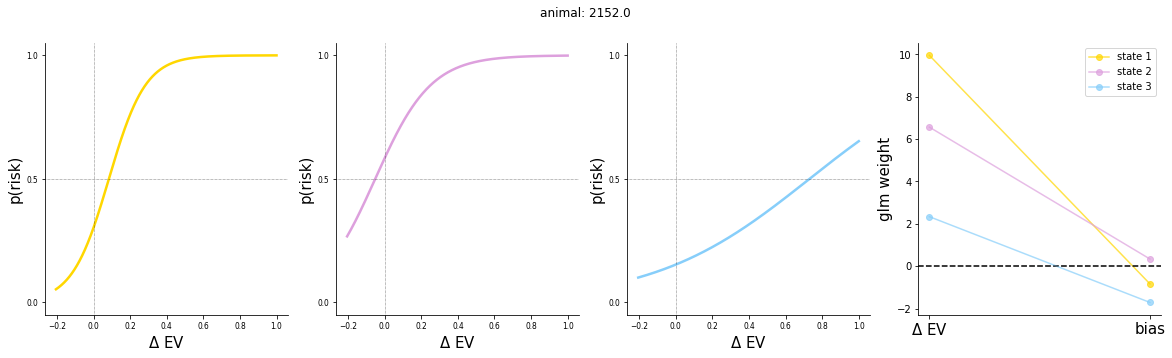

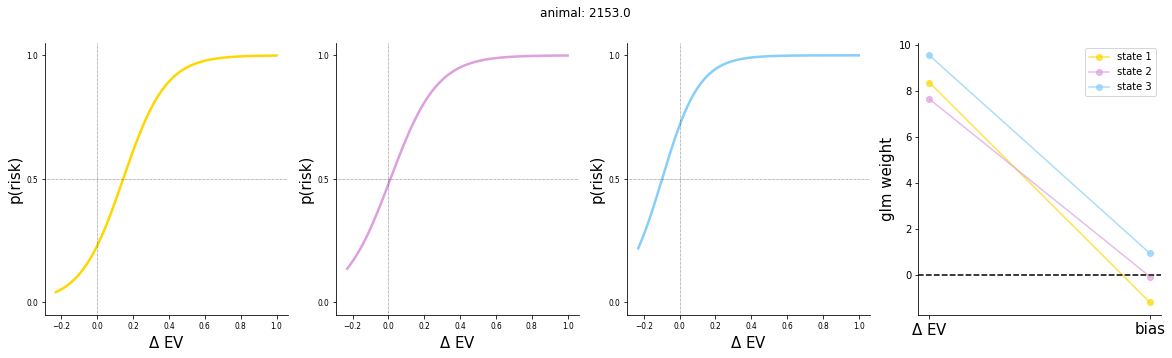

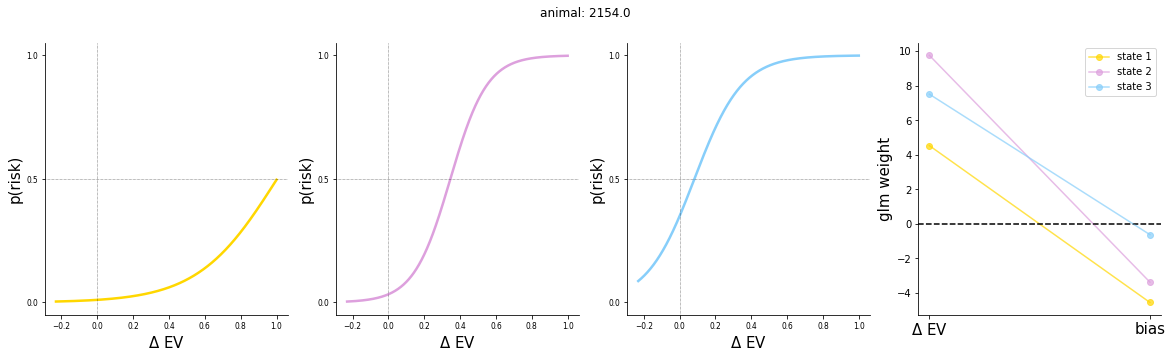

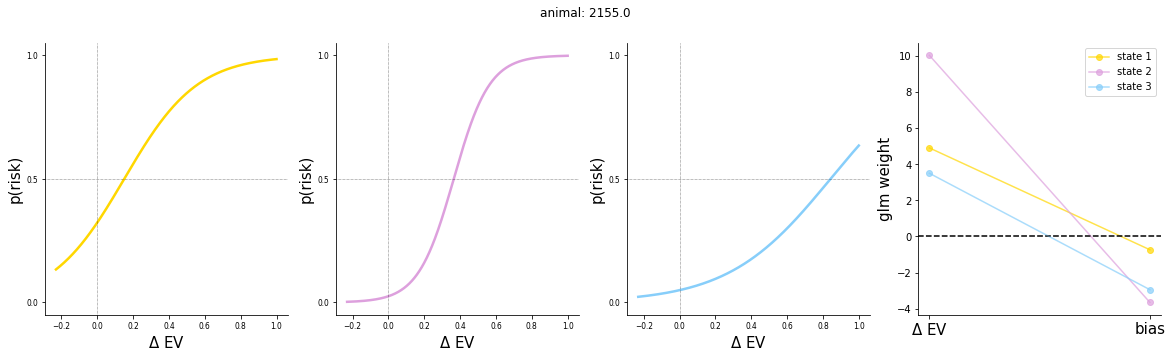

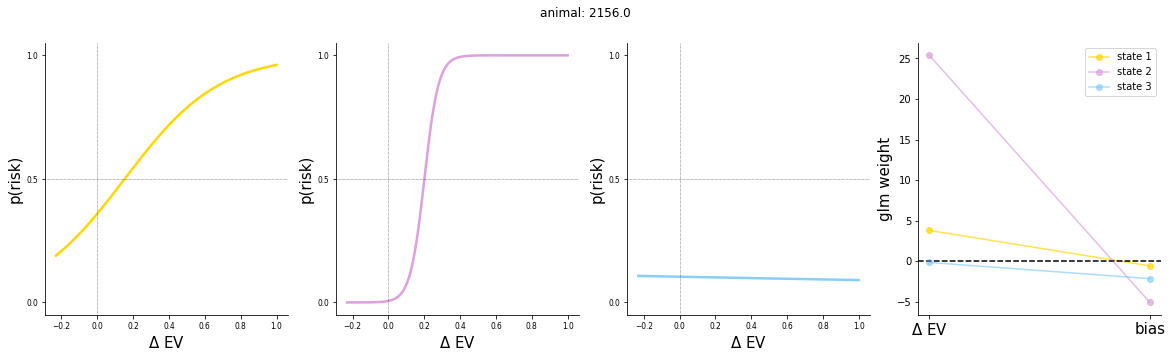

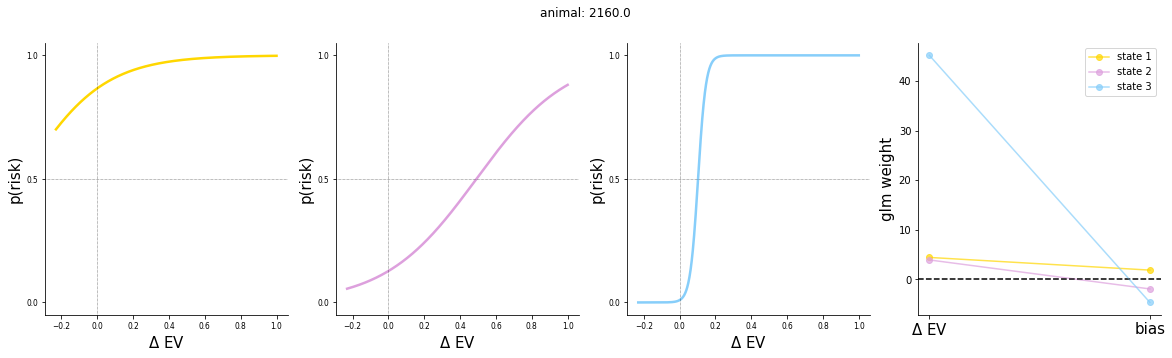

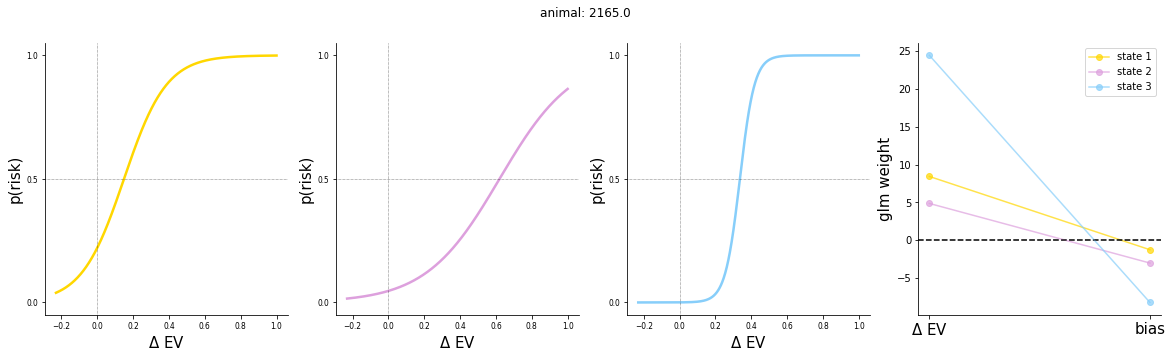

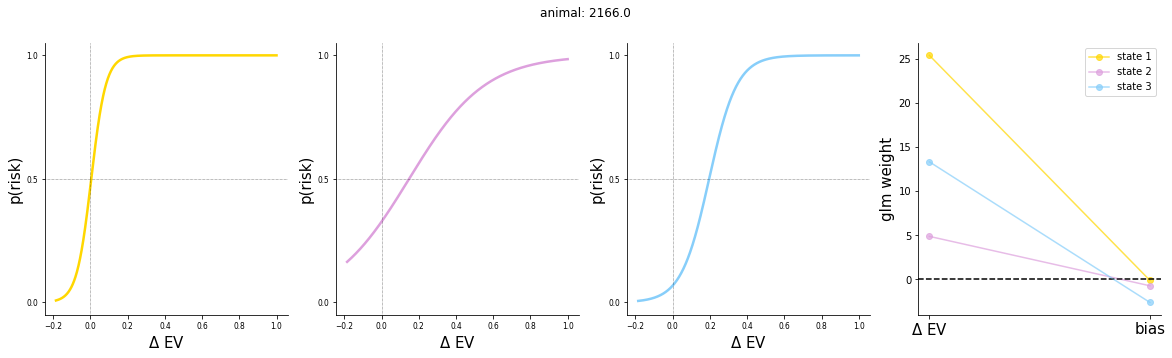

In [8]:
# plot glmhmm animal summaries
for aa in range(nanimals):
    fig, ax = plt.subplots(1, nstates + 1, figsize = (20,5))
    fig.suptitle('animal: ' + str(animals[aa]))
    
    evs = np.unique(inputs[aa][0][:,0])
    evspace = np.linspace(np.min(evs), np.max(evs), 1000)
    X = np.array([
        evspace,
        np.repeat(1, len(evspace))]).T
    
    for kk in range(nstates):       
        # plot psycurves
        plt.subplot(1, nstates + 1, kk + 1)
        
        glmweights = w[aa][kk, :]
        wX = np.matmul(X, glmweights)
        
        plt.plot(evspace, expit(wX), lw = 2.5, color = colors[kk])
        
        # reference lines
        plt.axvline(0, linestyle = ':', c = 'k',  lw = .5)
        plt.axhline(.5, linestyle = ':', c = 'k', lw = .5)
    
        # axis options
        plt.ylim((-.05, 1.05))
        plt.xlabel('$\Delta$ EV',  fontsize = 15)  
        plt.ylabel('p(risk)', fontsize = 15)
        ax[kk].set_yticks([0, .5, 1])
        plt.xticks(fontsize = 7.5)
        plt.yticks(fontsize = 7.5)
        ax[kk].spines['top'].set_visible(False)
        ax[kk].spines['right'].set_visible(False)
        
        # plot glm weights for each covariate
        plt.subplot(1, nstates + 1, nstates + 1)
        plt.plot(range(inputdim), glmweights, marker = 'o', 
                 color = colors[kk], alpha = .7, linestyle = '-', label = 'state ' + str(kk+1))

        plt.ylabel('glm weight', fontsize = 15)
        plt.xticks(range(inputdim), ['$\Delta$ EV ', 'bias'],  fontsize = 15)
        plt.axhline(y = 0, color = 'k', alpha = .5, ls = '--')
        plt.legend()
        ax[nstates].spines['top'].set_visible(False)
        ax[nstates].spines['right'].set_visible(False)

In [ ]:
# session summaries
for aa in range(nanimals):
    animaldata = df[df.animal == animals[aa]]
    sessions = animaldata.sessionid.unique()
    nsessions = len(sessions)
    
    for ss in range(nsessions):
        fig, ax = plt.subplots(1,1, figsize = (15,5))
        
        # getting session data
        sessiondata = animaldata[animaldata.sessionid == sessions[ss]]
        ntrials = len(sessiondata)
        lotteryoffer = np.array(sessiondata.lotterymag)
        lotteryofferset = np.unique(lotteryoffer)
        lotteryoutcome = np.array(sessiondata.choiceout)

        ## plotting p(state)
        plt.plot(range(ntrials), sessiondata.pstate1, color = colors[0], lw = 2.5)
        plt.plot(range(ntrials), sessiondata.pstate2, color = colors[1], lw = 2.5)
        plt.plot(range(ntrials), sessiondata.pstate3, color = colors[2], lw = 2.5)
        
        ## plotting trial type
        for tt in range(ntrials):
            # scatter lottery offer
            stimidx = np.where(lotteryoffer[tt] == lotteryofferset)[0][0]
            plt.scatter(tt, 1.1, marker = 's', color = stimcolors[stimidx], s = 25)
            
            # scatter lottery outcome
            if lotteryoutcome[tt] == 0:
                plt.scatter(tt, 1.15, marker = 'o', color = 'k', s = 25)
            elif lotteryoutcome[tt] == 1:
                plt.scatter(tt, 1.17, marker = 'o', color = 'g', s = 25)
            elif lotteryoutcome[tt] == -1:
                plt.scatter(tt, 1.19, marker = 'o', color = 'r', s = 25)
        
        # axis options
        plt.title('animal ' + str(animals[aa]) + ' - session number ' + str(ss + 1), fontsize = 15)
        plt.xlabel('trial number',  fontsize = 15)  
        plt.ylabel('p(state)', fontsize = 15)
        ax.set_yticks([0, .5, 1])
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
                

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


In [ ]:
# plot glmhmm animal summaries
for aa in range(nanimals):
    fig, ax = plt.subplots(2, nstates, figsize = (20,15))
    fig.suptitle('animal: ' + str(animals[aa]))
    
    evs = np.unique(inputs[aa][0][:,0])
    evspace = np.linspace(np.min(evs), np.max(evs), 1000)
    X = np.array([
        evspace,
        np.repeat(1, len(evspace))]).T
    
    for kk in range(nstates):       
        # plot psycurves
        plt.subplot(2, nstates, nstates + kk + 1)
        
        glmweights = w[aa][kk, :]
        wX = np.matmul(X, glmweights)
        
        plt.plot(evspace, expit(wX), lw = 2.5, color = colors[kk])
        
        # reference lines
        plt.axvline(0, linestyle = ':', c = 'k',  lw = .5)
        plt.axhline(.5, linestyle = ':', c = 'k', lw = .5)
    
        # axis options
        plt.ylim((-.05, 1.05))
        plt.xlabel('$\Delta$ EV',  fontsize = 15)  
        plt.ylabel('p(risk)', fontsize = 15)
#         ax[kk].set_yticks([0, .5, 1])
        plt.xticks(fontsize = 7.5)
        plt.yticks(fontsize = 7.5)
#         ax[kk].spines['top'].set_visible(False)
#         ax[kk].spines['right'].set_visible(False)
        
        # plot glm weights for each covariate
        plt.subplot(2, nstates, 1)
        plt.plot(range(inputdim), glmweights, marker = 'o', 
                 color = colors[kk], alpha = .7, linestyle = '-', label = 'state ' + str(kk+1))

        plt.ylabel('glm weight', fontsize = 15)
        plt.xticks(range(inputdim), ['$\Delta$ EV ', 'bias'],  fontsize = 15)
        plt.axhline(y = 0, color = 'k', alpha = .5, ls = '--')
        plt.legend()
#         ax[nstates].spines['top'].set_visible(False)
#         ax[nstates].spines['right'].set_visible(False)
        
        